In [1]:
import time
import os
import datetime
import random
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import haversine as hs
from matplotlib.patches import Patch
from haversine import Unit
from shapely.geometry import Point, Polygon, LineString
from math import radians, cos, sin, asin, sqrt
from collections import defaultdict

NOT_AVAILABLE_MSG = "No Available Trip in The Given Service Day"



In [2]:
trips_df = pd.read_csv("../../../data/mmt_gtfs/trips.csv")
routes_df = pd.read_csv("../../../data/mmt_gtfs/routes.csv")
stops_df = pd.read_csv("../../../data/bus_route_stop_info/stops.csv")
stops_df = stops_df[stops_df["Route"] != "None"]  # filter stops that are not currently in service
stop_times_df = pd.read_csv("../../../data/mmt_gtfs/stop_times.csv")
city = gpd.read_file("../../../data/plot/background/madison-shp")
water = gpd.read_file("../../../data/plot/background/water-shp")
street = gpd.read_file("../../../data/plot/background/streets-shp")
zones = gpd.read_file("../../../data/plot/background/zoning_districts-shp")
zones = zones.dropna(subset=["ZONING_COD"])

In [2]:
# service type
serv_types = {
    "wkd": ["93_WKD", "93_WKD:L#6", "93_WKD:L=6", "93_WKD:R",
            "93_WKD:S", "93_WKD:S#6", "93_WKD:S=6"],
    "sat": ["93_SAT", "93_SAT:L", "93_SAT:R", "93_SAT:S"],
    "sun": ["93_SUN", "93_SUN:L", "93_SUN:R", "93_SUN:S"],
    "hol": ["93_D24", "93_D31", "93_HOL", "93_HOL:R"],
    "mwk": ["93_MWK", "93_MWK:R"]}

zone_category = {
    "Residential Districts": [
        "SR-C1", "SR-C2", "SR-C3",
        "SR-V1", "SR-V2", "TR-C1",
        "TR-C2", "TR-C3", "TR-C4",
        "TR-V1", "TR-V2", "TR-U1",
        "TR-U2", "TR-R",  "TR-P"
    ],
    "Commercial and Mixed-Use Districts": [
        "LMX", "NMX", "TSS", "MXC", "CC-T", "CC"
    ],
    "Employment Districts": [
        "TE", "SE", "SEC", "EC", "IL", "IG"
    ],
    "Downtown and Urban Districts": [
        "DC", "UOR", "UMX", "DR1", "DR2"
    ],
    "Special Districts": [
        "A", "UA", "CN", "PR", "AP", "CI", "PD", "PMHP"
    ],
    "Overlay Districts": [
        "WP", "W", "TOD", "NC", "F1", "F2", "F3", "F4"
    ],
    "Historic Districts": [
        "HIST-L", "HIST-MH", "HIST-TL", "HIST-UH", "HIST-MB", "HIST-FS"
    ]
}

def generate_random(num_points, zones):
    """
    take as input a numpoints and a list of polygons,
    output a list of points within the given polygons

    :param num_points: number of points generated
    :param zones: zones shp file
    """
    points_by_zone = {}

    for key, val in zone_category.items():

        z = zones[zones["ZONING_COD"].isin(val)]
        if len(z) == 0:
            continue
        else:
            points_by_zone[key] = []
            while len(points_by_zone[key]) < num_points:
                choice_idx = random.choice(range(len(z)))
                polygon = z.iloc[choice_idx, -1]
                minx, miny, maxx, maxy = polygon.bounds
                # pnt = Point(random.uniform(round(minx, 2), round(maxx, 2)),
                #             random.uniform(round(miny, 2), round(maxy, 2)))
                pnt = Point(random.uniform(minx, maxx),
                            random.uniform(miny, maxy))
                if polygon.contains(pnt):
                    points_by_zone[key].append(pnt)
    return points_by_zone

def plot_random(num_points, zones, ax, **kwargs):

    # -----------------------------------------------------------------------
    # --- hard coded colors indicating different districts ------------------
    # --- may need to add more colors when more categories are added --------
    colors = ["tab:blue", "tab:orange", "tab:green", "tab:purple", "tab:olive"]
    # -----------------------------------------------------------------------

    handles = []
    points = generate_random(num_points, zones)  # points_by_zone
    c_pick = 0
    for key, pts in points.items():
        c = colors[c_pick]
        c_pick += 1
        x = []
        y = []
        for pt in pts:
            x.append(float(pt.x))
            y.append(float(pt.y))
        handle = plt.scatter(x, y, c=c, **kwargs)
        handles.append(handle)
    plt.legend(handles=handles, labels=points.keys(), frameon=False, loc="upper left")

    return points


def find_nearest(points):
    """
    Find the nearest bus stops for each point in the points parameter.

    :param points: a list of shapely Point objects
    :return: a DataFrame of columns: stop_id, lon, lat, distance in miles
    """
    ids = []
    stop_lons = []
    stop_lats = []
    pt_lons = []
    pt_lats = []
    dists = []
    districts = []

    for key, pts in points.items():
        for pt in pts:
            x = pt.x
            y = pt.y

            # element wise operation to find the smallest value
            euclidean = (stops_df["stop_lon"] - x) ** 2 + (stops_df["stop_lat"] - y) ** 2
            idx = euclidean.idxmin()  # index of the smallest value

            stop_id = stops_df.loc[euclidean.idxmin(), "stop_id"]
            lon = stops_df.loc[euclidean.idxmin(), "stop_lon"]
            lat = stops_df.loc[euclidean.idxmin(), "stop_lat"]
            dist = hs.haversine((x, y), (lon, lat), unit=Unit.MILES)  # in miles
            dist = dist * 1609.34  # convert miles to meters

            ids.append(stop_id)
            stop_lons.append(lon)
            stop_lats.append(lat)
            pt_lons.append(x)
            pt_lats.append(y)
            dists.append(dist)
            districts.append(key)
    stops = pd.DataFrame({
        "districts": districts,
        "stop_id": ids,
        "stop_lon": stop_lons,
        "stop_lat": stop_lats,
        "pt_lon": pt_lons,
        "pt_lat": pt_lats,
        "distance (in meters)": dists
    })
    return stops

def connect_to_stops(ax, stops):
    """
    Draw a line from randomly generated points to nearest bus stops that are in service.

    :param ax: Axes object to plot
    :param stops: stops dataframe that have columns stop_id, lat, lon, dist
    :return: None
    """
    linestrings = []
    for idx, row in stops.iterrows():
        ls = LineString([(row["pt_lon"], row["pt_lat"]), (row["stop_lon"], row["stop_lat"])])
        linestrings.append(ls)

    df = pd.DataFrame({"geometry":linestrings})
    df.set_geometry("geometry").plot(ax=ax, color="k", linestyle="--", alpha=0.5)

def minute_wait(stops, t, serv):
    """

    :param stops:
    :return:
    """

    # filtered trips by service type
    trips_by_serv = trips_df[trips_df["service_id"].isin(serv_types[serv])]

    min_trip_ids = []
    min_waits = []

    for idx, row in stops.iterrows():
        # stop_times_df["stop_id"] x stops["stop_id"]
        matched_stops = stop_times_df[stop_times_df["stop_id"].isin([row["stop_id"]])]

        # filtered_trip["trip_id"] x matched_stops["trip_id"]
        filtered_trips = trips_by_serv[trips_by_serv["trip_id"].isin(matched_stops["trip_id"])]

        # matched_stops["trip_id"] x filtered_trips["trip_id"]
        matched = matched_stops[matched_stops["trip_id"].isin(filtered_trips["trip_id"])]

        # find waiting time for the soonest coming route and trip_id of that route
        trip_min = 0
        wait_min = float("inf")
        for idx1, row1 in matched.iterrows():
            arrival = row1["arrival_time"].split(":")
            arr_td = datetime.timedelta(hours=int(arrival[0]), minutes=int(arrival[1]), seconds=int(arrival[2]))
            td = datetime.timedelta(hours=t.hour, minutes=t.minute, seconds=t.second)
            time_diff = arr_td - td

            # find minimum wating time and the trip id
            if time_diff.days == 0 and time_diff.seconds < wait_min:
                wait_min = time_diff.seconds
                trip_min = row1["trip_id"]

        if trip_min == 0 and wait_min == float("inf"):
            min_trip_ids.append(None)
            min_waits.append(None)
        else:
            min_trip_ids.append(int(trip_min))
            min_waits.append(round(wait_min / 60, 2))

    stops["minutes_wait"] = min_waits
    stops["trip_id"] = min_trip_ids

    # find the route that's coming by trip_id
    route_coming = []

    for idx, row in stops.iterrows():
        trip_id = row["trip_id"]
        if np.isnan(trip_id):
            route_coming.append(NOT_AVAILABLE_MSG)
        else:
            route_coming.append(trips_df[trips_df["trip_id"].isin([trip_id])]["route_short_name"].iloc[0])
    stops["coming_route"] = route_coming

    return stops

def get_service_type(serv):
    if serv == "wkd":
        return " on Weekday"
    if serv == "sat":
        return " on Saturday"
    if serv == "sun":
        return " on Sunday"
    if serv == "hol":
        return " on Holiday"
    else:
        return " on Modified Week"

def get_full_time(t):
    return " at " + str(t.hour) + ":" + str(t.minute) + ":" + str(t.second)


def generate_plot(num_points, t, serv):
    """
    generate a geo map with randomly generated points, and connect the
    generated points with the nearest bus stops

    :param num_points: number of random points to be generated, user input
    :return: TBD
    """

    # --------- plot background ---------
    fig, ax = plt.subplots(figsize=(12, 10))
    city.plot(ax=ax, color="0.9")
    water.plot(ax=ax, color="0.7")
    street.plot(ax=ax, color="0.8")

    dot_size = 20
    # --------- plot random points ---------
    start = time.time()
    points = plot_random(num_points=num_points, zones=zones, ax=ax, s=dot_size, zorder=5, alpha=0.4)
    end = time.time()
    print("plot random points " + str(round((end - start) * 1000, 2)) + "ms")

    # --------- plot bus stops ---------
    start = time.time()
    stops = find_nearest(points)
    # stops.plot.scatter("lon", "lat", ax=ax, c=colors, s=35, zorder=5, alpha=0.4, marker='o', facecolor="None")
    plt.plot(stops["stop_lon"],stops["stop_lat"], 'x', markersize=dot_size*0.3, markerfacecolor="None",
             markeredgecolor="red", markeredgewidth=0.5, alpha=0.3, zorder=5, label="Bus Stop")
    end = time.time()
    print("plot bus stops " + str(round((end - start) * 1000, 2)) + "ms")

    # --------- draw lines between pts and stops ---------
    start = time.time()
    connect_to_stops(ax, stops)

    end = time.time()
    print("draw lines between pts and stops " + str(round((end - start) * 1000, 2)) + "ms")

    # --------- save figure to file ---------
    # TODO: when save, uncomment this

    start = time.time()
    ax.set_axis_off()
    ax.set_title(str(num_points) + " Random Samples Per Zone, " + str(num_points * 5) + " in Total" + get_full_time(t) + get_service_type(serv), size=16)

    if not os.path.exists("sim_sample"):
        os.mkdir("sim_sample")

    current_time = datetime.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d_%H-%M-%S')
    dirname = current_time[:current_time.index("_")]

    if not os.path.exists(os.path.join("sim_sample", dirname)):
        os.mkdir(os.path.join("sim_sample", dirname))

    plt.savefig(os.path.join("sim_sample",
                             dirname,
                            (current_time[current_time.index("_"):] + ".png")),
                dpi=300, bbox_inches="tight")
    end = time.time()
    print("saving figure " + str(round((end - start) * 1000, 2)) + "ms")


    # --------- add available routes to stops ---------
    start = time.time()
    routes = []
    num_routes = []
    for idx, row in stops.iterrows():
        stop_id = row["stop_id"]
        temp = stops_df[stops_df["stop_id"].isin([stop_id])]["Route"]
        routes.append(temp.iloc[0])
        num_routes.append(len(temp.iloc[0].split(", ")))

    stops["available_routes"] = routes
    stops["num_available_routes"] = num_routes
    end = time.time()
    print("add routes to stops " + str(round((end - start) * 1000, 2)) + "ms")

    # --------- find soonest coming bus, given time "t" and service type "serv" ---------
    start = time.time()
    stops = minute_wait(stops, t, serv)
    end = time.time()
    print("find soonest coming bus " + str(round((end - start) * 1000, 2)) + "ms")

    return stops

t = datetime.time(7, 30, 00)
serv = "wkd"
start = time.time()
stops = generate_plot(200, t, serv)  # meaning each district will have 200 random points -> 1000 random samples
end = time.time()
print("total execution time " + str(round((end - start) * 1000, 2)) + "ms")

NameError: name 'datetime' is not defined

In [3]:
# color map
# 1. waiting time
# 2. available routes
# 3. walking distance to bus stops

# TODO: 1. start simulation!!!!!!!!!!!!!!!!
# 1. distance to bus stop  (take the mean)
# 2. # of available routes
# 3. minute wait  (avg and mean)
# 4.

# TODO: 2. ADD number of boarding at each stop!!!!!!!!!!!!!!!

stops.head(3)

NameError: name 'stops' is not defined

plot random points 879.79ms
plot bus stops 2406.87ms
draw lines between pts and stops 460.9ms
saving figure 1529.87ms
add routes to stops 1636.32ms
find soonest coming bus 17890.15ms
plot random points 673.55ms
plot bus stops 2125.32ms
draw lines between pts and stops 456.95ms
saving figure 1537.53ms
add routes to stops 1336.46ms
find soonest coming bus 17210.59ms
plot random points 648.3ms
plot bus stops 2232.1ms
draw lines between pts and stops 469.96ms
saving figure 1590.33ms
add routes to stops 1371.83ms
find soonest coming bus 17372.69ms
plot random points 644.59ms
plot bus stops 2170.08ms
draw lines between pts and stops 490.88ms
saving figure 1602.26ms
add routes to stops 1378.79ms
find soonest coming bus 13770.47ms
plot random points 658.21ms
plot bus stops 2262.78ms
draw lines between pts and stops 466.97ms
saving figure 1528.07ms
add routes to stops 1404.55ms
find soonest coming bus 13857.99ms
plot random points 662.52ms
plot bus stops 2236.78ms
draw lines between pts and sto

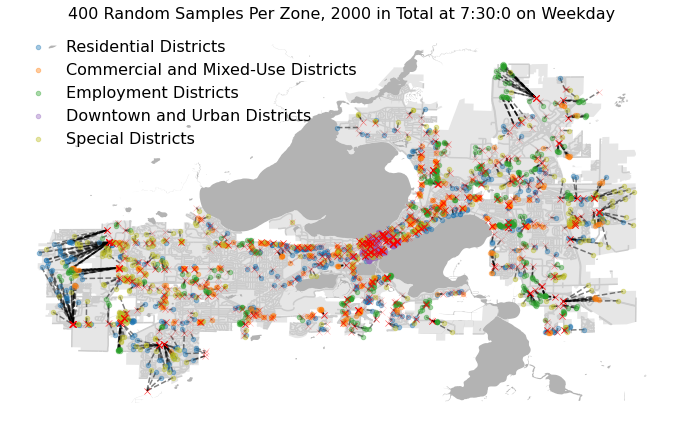

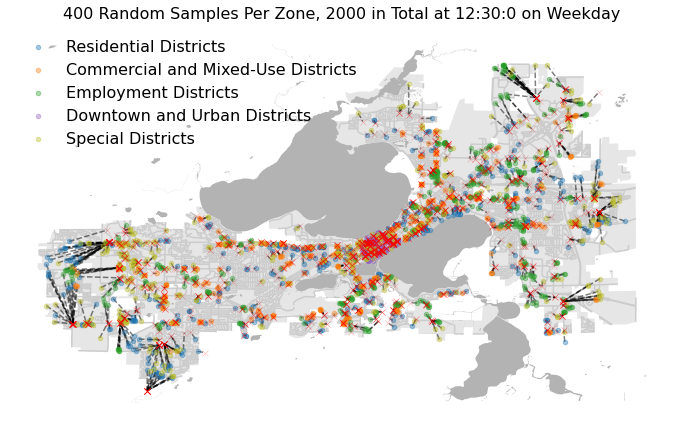

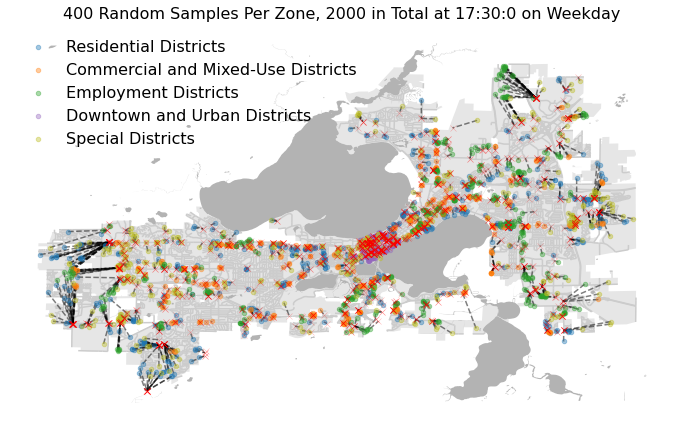

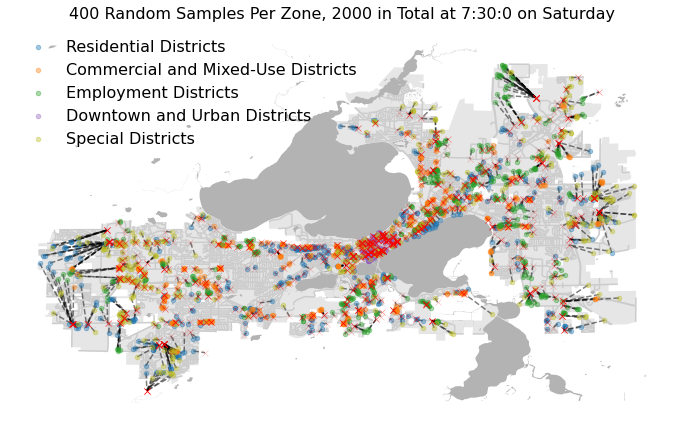

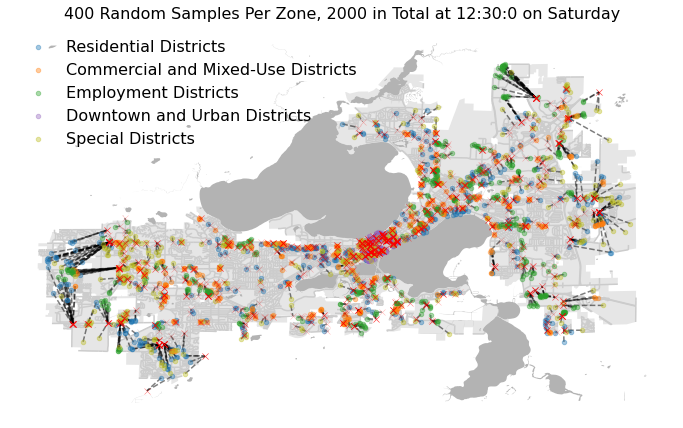

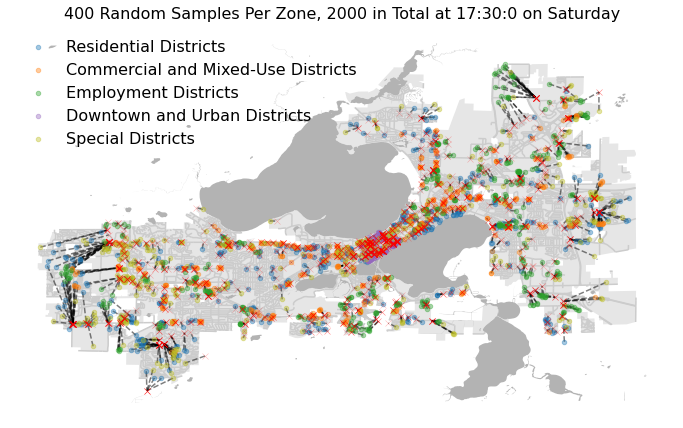

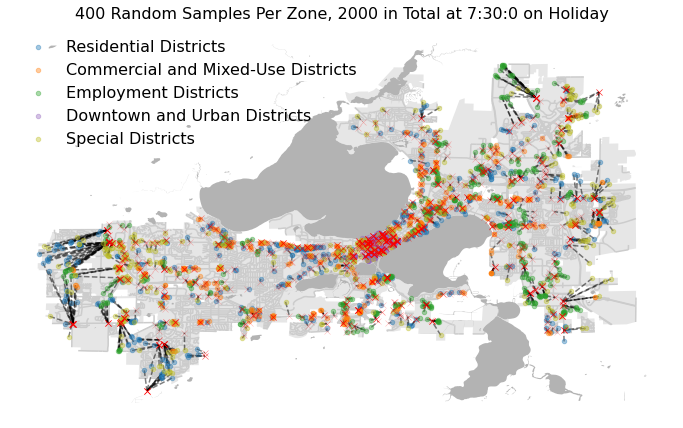

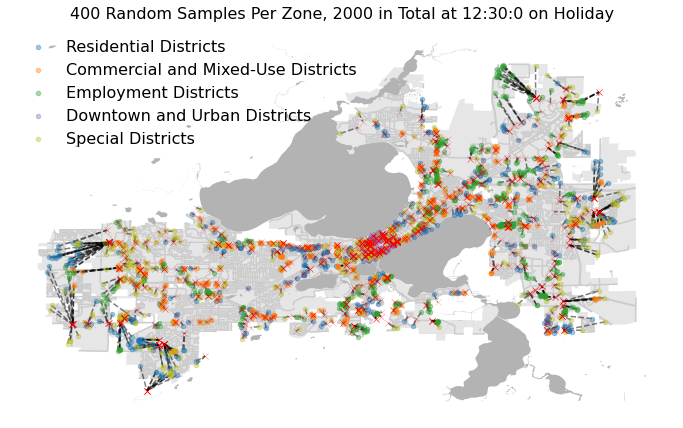

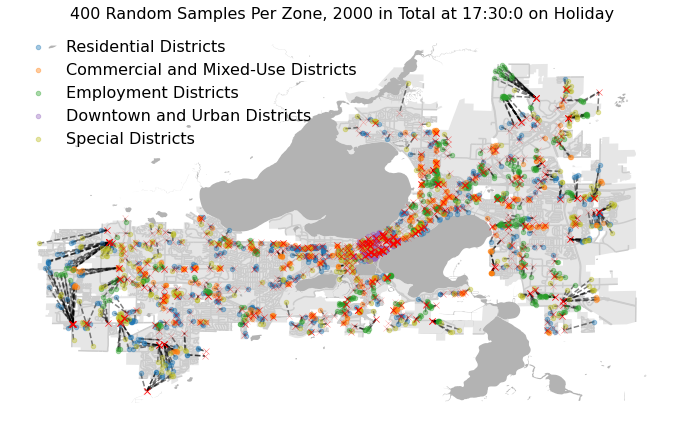

In [36]:
# start = time.time()
# s1 = generate_plot(400, datetime.time(7, 30, 00), "wkd")
# s2 = generate_plot(400, datetime.time(12, 30, 00), "wkd")
# s3 = generate_plot(400, datetime.time(17, 30, 00), "wkd")
# s4 = generate_plot(400, datetime.time(7, 30, 00), "sat")
# s5 = generate_plot(400, datetime.time(12, 30, 00), "sat")
# s6 = generate_plot(400, datetime.time(17, 30, 00), "sat")
# s7 = generate_plot(400, datetime.time(7, 30, 00), "hol")
# s8 = generate_plot(400, datetime.time(12, 30, 00), "hol")
# s9 = generate_plot(400, datetime.time(17, 30, 00), "hol")
# end = time.time()
# print("total execution time " + str(round((end - start) * 1000, 2)) + "ms")

In [37]:
# ds  = list(zone_category.keys())[:5]
# d1_1 = s1[s1["districts"] == ds[0]]
# d1_2 = s1[s1["districts"] == ds[1]]
# d1_3 = s1[s1["districts"] == ds[2]]
# d1_4 = s1[s1["districts"] == ds[3]]
# d1_5 = s1[s1["districts"] == ds[4]]
#
# d2_1 = s2[s2["districts"] == ds[0]]
# d2_2 = s2[s2["districts"] == ds[1]]
# d2_3 = s2[s2["districts"] == ds[2]]
# d2_4 = s2[s2["districts"] == ds[3]]
# d2_5 = s2[s2["districts"] == ds[4]]
#
# d3_1 = s3[s3["districts"] == ds[0]]
# d3_2 = s3[s3["districts"] == ds[1]]
# d3_3 = s3[s3["districts"] == ds[2]]
# d3_4 = s3[s3["districts"] == ds[3]]
# d3_5 = s3[s3["districts"] == ds[4]]
#
# d4_1 = s4[s4["districts"] == ds[0]]
# d4_2 = s4[s4["districts"] == ds[1]]
# d4_3 = s4[s4["districts"] == ds[2]]
# d4_4 = s4[s4["districts"] == ds[3]]
# d4_5 = s4[s4["districts"] == ds[4]]
#
# d5_1 = s5[s5["districts"] == ds[0]]
# d5_2 = s5[s5["districts"] == ds[1]]
# d5_3 = s5[s5["districts"] == ds[2]]
# d5_4 = s5[s5["districts"] == ds[3]]
# d5_5 = s5[s5["districts"] == ds[4]]
#
# d6_1 = s6[s6["districts"] == ds[0]]
# d6_2 = s6[s6["districts"] == ds[1]]
# d6_3 = s6[s6["districts"] == ds[2]]
# d6_4 = s6[s6["districts"] == ds[3]]
# d6_5 = s6[s6["districts"] == ds[4]]
#
# d7_1 = s7[s7["districts"] == ds[0]]
# d7_2 = s7[s7["districts"] == ds[1]]
# d7_3 = s7[s7["districts"] == ds[2]]
# d7_4 = s7[s7["districts"] == ds[3]]
# d7_5 = s7[s7["districts"] == ds[4]]
#
# d8_1 = s8[s8["districts"] == ds[0]]
# d8_2 = s8[s8["districts"] == ds[1]]
# d8_3 = s8[s8["districts"] == ds[2]]
# d8_4 = s8[s8["districts"] == ds[3]]
# d8_5 = s8[s8["districts"] == ds[4]]
#
# d9_1 = s9[s9["districts"] == ds[0]]
# d9_2 = s9[s9["districts"] == ds[1]]
# d9_3 = s9[s9["districts"] == ds[2]]
# d9_4 = s9[s9["districts"] == ds[3]]
# d9_5 = s9[s9["districts"] == ds[4]]


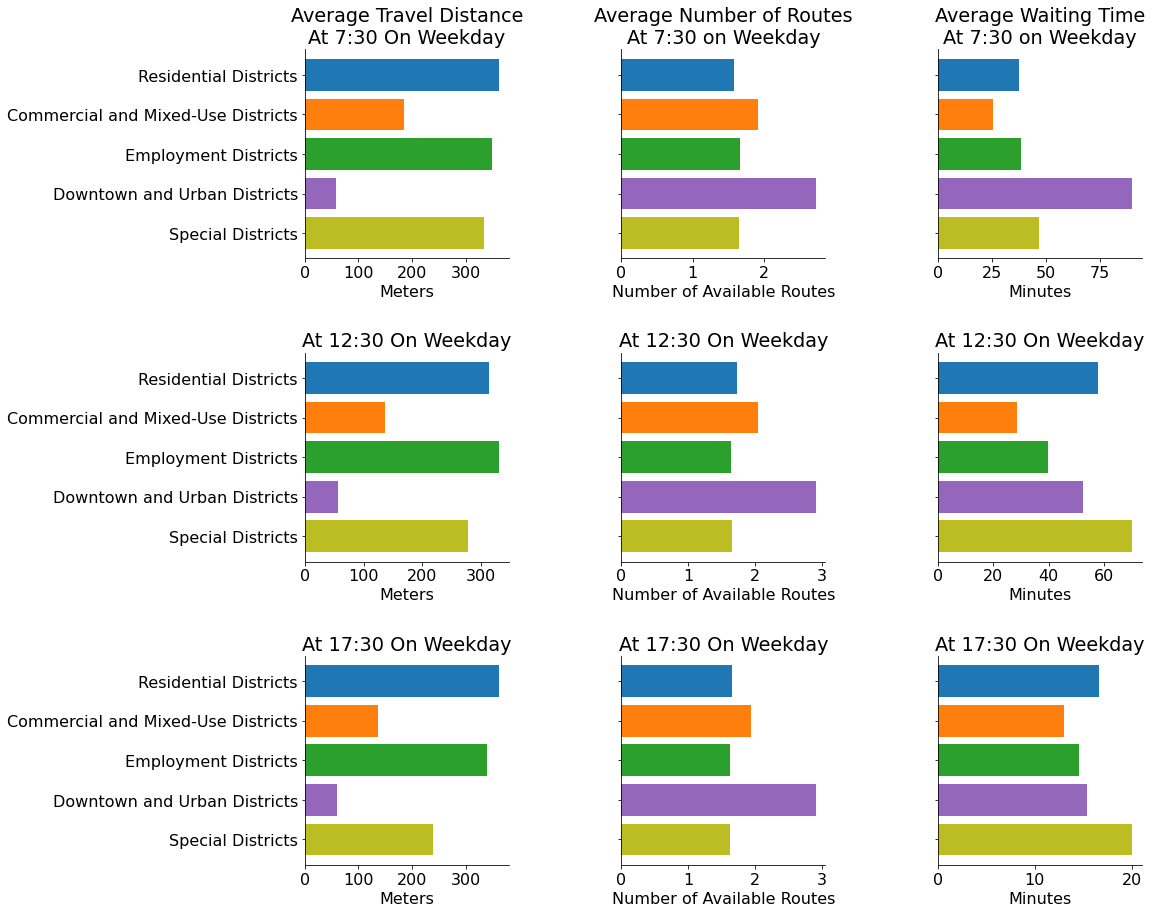

In [38]:
colors = ["tab:blue", "tab:orange", "tab:green", "tab:purple", "tab:olive"]
#####################  REPORT of 1116.md  #####################

#####################  wkd  #####################
fig, ((ax1, ax2, ax3),
      (ax4, ax5, ax6),
      (ax7, ax8, ax9)) = plt.subplots(ncols=3, nrows=3, figsize=(15, 15), sharey=True)
plt.rcParams["font.size"] = 16
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.subplots_adjust(hspace=0.45, wspace=0.55)


##################### ax1 - 3:  #####################
# ax1 7:30 weekday walking distance to bus stops
ax1.barh(ds, [d1_1["distance (in meters)"].mean(),
              d1_2["distance (in meters)"].mean(),
              d1_3["distance (in meters)"].mean(),
              d1_4["distance (in meters)"].mean(),
              d1_5["distance (in meters)"].mean()], align='center', color=colors, linewidth=3.5)
ax1.invert_yaxis()  # labels read top-to-bottom
ax1.set_title('Average Travel Distance\nAt 7:30 On Weekday')
ax1.set_xlabel('Meters')

# ax2 7:30 weekday number of available routes
ax2.barh(ds, [d1_1["num_available_routes"].mean(),
              d1_2["num_available_routes"].mean(),
              d1_3["num_available_routes"].mean(),
              d1_4["num_available_routes"].mean(),
              d1_5["num_available_routes"].mean()], align='center', color=colors, linewidth=3.5)
ax2.invert_yaxis()  # labels read top-to-bottom
ax2.set_title('Average Number of Routes\nAt 7:30 on Weekday')
ax2.set_xlabel('Number of Available Routes')

# ax3 7:30 weekday waiting time
ax3.barh(ds, [d1_1["minutes_wait"].dropna().mean(),
              d1_2["minutes_wait"].dropna().mean(),
              d1_3["minutes_wait"].dropna().mean(),
              d1_4["minutes_wait"].dropna().mean(),
              d1_5["minutes_wait"].dropna().mean()], align='center', color=colors, linewidth=3.5)
ax3.invert_yaxis()  # labels read top-to-bottom
ax3.set_title('Average Waiting Time\nAt 7:30 on Weekday')
ax3.set_xlabel('Minutes')

##################### ax4 - 6:  #####################
# ax4 12:30 weekday walking distance to bus stops
ax4.barh(ds, [d2_1["distance (in meters)"].mean(),
              d2_2["distance (in meters)"].mean(),
              d2_3["distance (in meters)"].mean(),
              d2_4["distance (in meters)"].mean(),
              d2_5["distance (in meters)"].mean()], align='center', color=colors, linewidth=3.5)
ax4.invert_yaxis()  # labels read top-to-bottom
ax4.set_title('At 12:30 On Weekday')
ax4.set_xlabel('Meters')

# ax5 12:30 weekday number of available routes
ax5.barh(ds, [d2_1["num_available_routes"].mean(),
              d2_2["num_available_routes"].mean(),
              d2_3["num_available_routes"].mean(),
              d2_4["num_available_routes"].mean(),
              d2_5["num_available_routes"].mean()], align='center', color=colors, linewidth=3.5)
ax5.invert_yaxis()  # labels read top-to-bottom
ax5.set_title('At 12:30 On Weekday')
ax5.set_xlabel('Number of Available Routes')

# ax6 12:30 weekday waiting time
ax6.barh(ds, [d2_1["minutes_wait"].dropna().mean(),
              d2_2["minutes_wait"].dropna().mean(),
              d2_3["minutes_wait"].dropna().mean(),
              d2_4["minutes_wait"].dropna().mean(),
              d2_5["minutes_wait"].dropna().mean()], align='center', color=colors, linewidth=3.5)
ax6.invert_yaxis()  # labels read top-to-bottom
ax6.set_title('At 12:30 On Weekday')
ax6.set_xlabel('Minutes')


##################### ax7 - 9:  #####################
# ax7 17:30 weekday walking distance to bus stops
ax7.barh(ds, [d1_1["distance (in meters)"].mean(),
              d2_2["distance (in meters)"].mean(),
              d3_3["distance (in meters)"].mean(),
              d4_4["distance (in meters)"].mean(),
              d5_5["distance (in meters)"].mean()], align='center', color=colors, linewidth=3.5)
ax7.invert_yaxis()  # labels read top-to-bottom
ax7.set_title('At 17:30 On Weekday')
ax7.set_xlabel('Meters')

# ax8 17:30 weekday number of available routes
ax8.barh(ds, [d3_1["num_available_routes"].mean(),
              d3_2["num_available_routes"].mean(),
              d3_3["num_available_routes"].mean(),
              d3_4["num_available_routes"].mean(),
              d3_5["num_available_routes"].mean()], align='center', color=colors, linewidth=3.5)
ax8.invert_yaxis()  # labels read top-to-bottom
ax8.set_title('At 17:30 On Weekday')
ax8.set_xlabel('Number of Available Routes')

# ax9 17:30 weekday waiting time
ax9.barh(ds, [d3_1["minutes_wait"].dropna().mean(),
              d3_2["minutes_wait"].dropna().mean(),
              d3_3["minutes_wait"].dropna().mean(),
              d3_4["minutes_wait"].dropna().mean(),
              d3_5["minutes_wait"].dropna().mean()], align='center', color=colors, linewidth=3.5)
ax9.invert_yaxis()  # labels read top-to-bottom
ax9.set_title('At 17:30 On Weekday')
ax9.set_xlabel('Minutes')
plt.savefig("../report/11_16th/weekday_png", dpi=300, bbox_inches="tight")

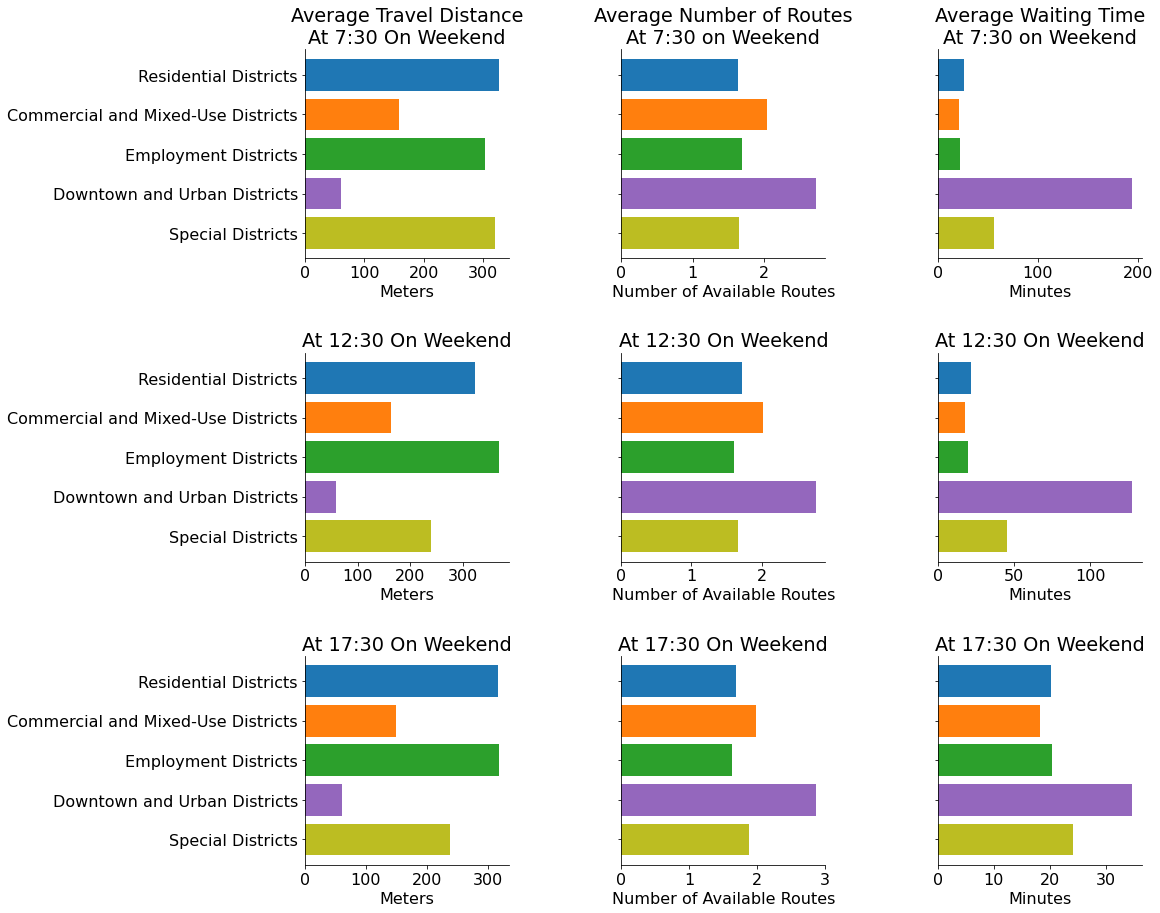

In [39]:
#####################  weekend  #####################
fig, ((ax1, ax2, ax3),
      (ax4, ax5, ax6),
      (ax7, ax8, ax9)) = plt.subplots(ncols=3, nrows=3, figsize=(15, 15), sharey=True)
plt.rcParams["font.size"] = 16
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.subplots_adjust(hspace=0.45, wspace=0.55)


##################### ax1 - 3:  #####################
# ax1 7:30 Weekend walking distance to bus stops
ax1.barh(ds, [d4_1["distance (in meters)"].mean(),
              d4_2["distance (in meters)"].mean(),
              d4_3["distance (in meters)"].mean(),
              d4_4["distance (in meters)"].mean(),
              d4_5["distance (in meters)"].mean()], align='center', color=colors, linewidth=3.5)
ax1.invert_yaxis()  # labels read top-to-bottom
ax1.set_title('Average Travel Distance\nAt 7:30 On Weekend')
ax1.set_xlabel('Meters')

# ax2 7:30 weekday number of available routes
ax2.barh(ds, [d4_1["num_available_routes"].mean(),
              d4_2["num_available_routes"].mean(),
              d4_3["num_available_routes"].mean(),
              d4_4["num_available_routes"].mean(),
              d4_5["num_available_routes"].mean()], align='center', color=colors, linewidth=3.5)
ax2.invert_yaxis()  # labels read top-to-bottom
ax2.set_title('Average Number of Routes\nAt 7:30 on Weekend')
ax2.set_xlabel('Number of Available Routes')

# ax3 7:30 Weekend waiting time
ax3.barh(ds, [d4_1["minutes_wait"].dropna().mean(),
              d4_2["minutes_wait"].dropna().mean(),
              d4_3["minutes_wait"].dropna().mean(),
              d4_4["minutes_wait"].dropna().mean(),
              d4_5["minutes_wait"].dropna().mean()], align='center', color=colors, linewidth=3.5)
ax3.invert_yaxis()  # labels read top-to-bottom
ax3.set_title('Average Waiting Time\nAt 7:30 on Weekend')
ax3.set_xlabel('Minutes')

##################### ax4 - 6:  #####################
# ax4 12:30 Weekend walking distance to bus stops
ax4.barh(ds, [d5_1["distance (in meters)"].mean(),
              d5_2["distance (in meters)"].mean(),
              d5_3["distance (in meters)"].mean(),
              d5_4["distance (in meters)"].mean(),
              d5_5["distance (in meters)"].mean()], align='center', color=colors, linewidth=3.5)
ax4.invert_yaxis()  # labels read top-to-bottom
ax4.set_title('At 12:30 On Weekend')
ax4.set_xlabel('Meters')

# ax5 12:30 Weekend number of available routes
ax5.barh(ds, [d5_1["num_available_routes"].mean(),
              d5_2["num_available_routes"].mean(),
              d5_3["num_available_routes"].mean(),
              d5_4["num_available_routes"].mean(),
              d5_5["num_available_routes"].mean()], align='center', color=colors, linewidth=3.5)
ax5.invert_yaxis()  # labels read top-to-bottom
ax5.set_title('At 12:30 On Weekend')
ax5.set_xlabel('Number of Available Routes')

# ax6 12:30 Weekend waiting time
ax6.barh(ds, [d5_1["minutes_wait"].dropna().mean(),
              d5_2["minutes_wait"].dropna().mean(),
              d5_3["minutes_wait"].dropna().mean(),
              d5_4["minutes_wait"].dropna().mean(),
              d5_5["minutes_wait"].dropna().mean()], align='center', color=colors, linewidth=3.5)
ax6.invert_yaxis()  # labels read top-to-bottom
ax6.set_title('At 12:30 On Weekend')
ax6.set_xlabel('Minutes')


##################### ax7 - 9:  #####################
# ax7 17:30 Weekend walking distance to bus stops
ax7.barh(ds, [d6_1["distance (in meters)"].mean(),
              d6_2["distance (in meters)"].mean(),
              d6_3["distance (in meters)"].mean(),
              d6_4["distance (in meters)"].mean(),
              d6_5["distance (in meters)"].mean()], align='center', color=colors, linewidth=3.5)
ax7.invert_yaxis()  # labels read top-to-bottom
ax7.set_title('At 17:30 On Weekend')
ax7.set_xlabel('Meters')

# ax8 17:30 Weekend number of available routes
ax8.barh(ds, [d6_1["num_available_routes"].mean(),
              d6_2["num_available_routes"].mean(),
              d6_3["num_available_routes"].mean(),
              d6_4["num_available_routes"].mean(),
              d6_5["num_available_routes"].mean()], align='center', color=colors, linewidth=3.5)
ax8.invert_yaxis()  # labels read top-to-bottom
ax8.set_title('At 17:30 On Weekend')
ax8.set_xlabel('Number of Available Routes')

# ax9 17:30 Weekend waiting time
ax9.barh(ds, [d6_1["minutes_wait"].dropna().mean(),
              d6_2["minutes_wait"].dropna().mean(),
              d6_3["minutes_wait"].dropna().mean(),
              d6_4["minutes_wait"].dropna().mean(),
              d6_5["minutes_wait"].dropna().mean()], align='center', color=colors, linewidth=3.5)
ax9.invert_yaxis()  # labels read top-to-bottom
ax9.set_title('At 17:30 On Weekend')
ax9.set_xlabel('Minutes')
plt.savefig("../report/11_16th/weekend_png", dpi=300, bbox_inches="tight")


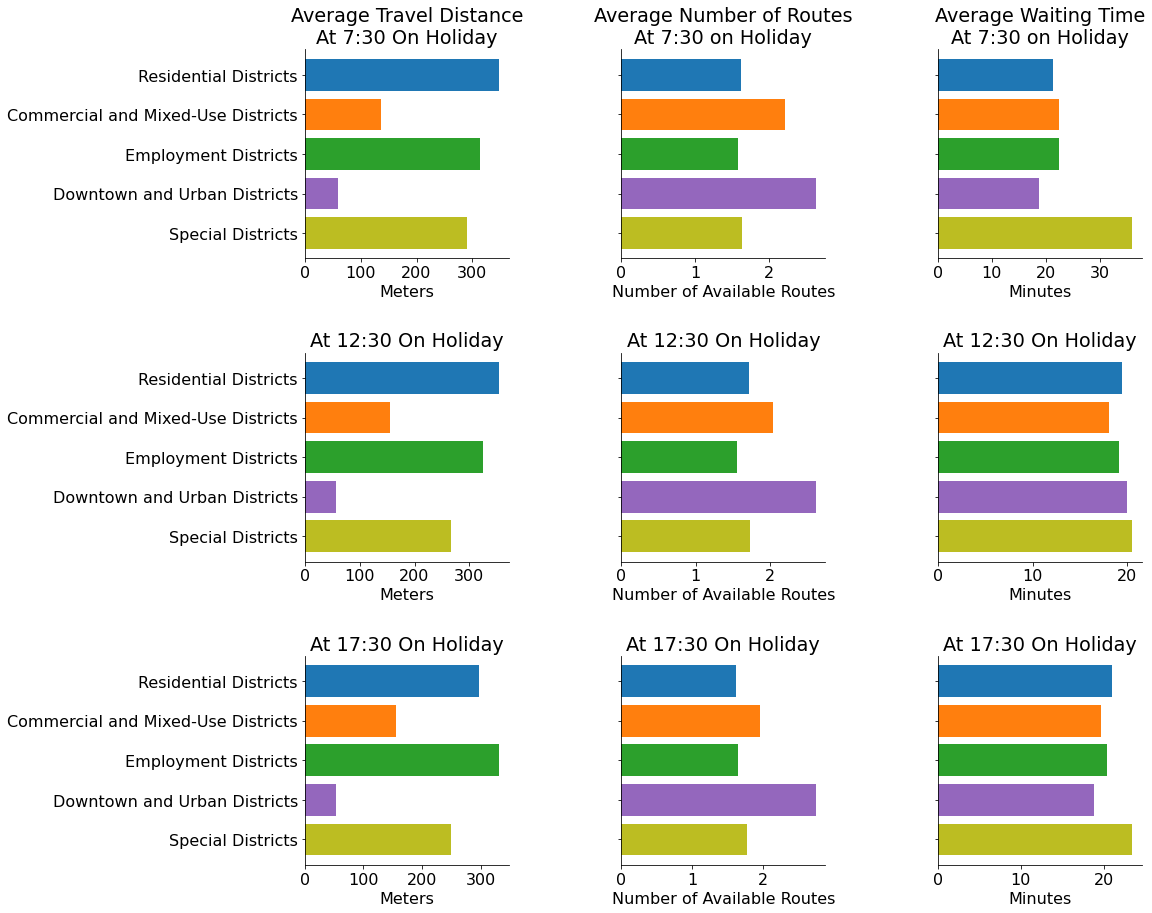

In [40]:
#####################  hol  #####################
fig, ((ax1, ax2, ax3),
      (ax4, ax5, ax6),
      (ax7, ax8, ax9)) = plt.subplots(ncols=3, nrows=3, figsize=(15, 15), sharey=True)
plt.rcParams["font.size"] = 16
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.subplots_adjust(hspace=0.45, wspace=0.55)


##################### ax1 - 3:  #####################
# ax1 7:30 Holiday walking distance to bus stops
ax1.barh(ds, [d7_1["distance (in meters)"].mean(),
              d7_2["distance (in meters)"].mean(),
              d7_3["distance (in meters)"].mean(),
              d7_4["distance (in meters)"].mean(),
              d7_5["distance (in meters)"].mean()], align='center', color=colors, linewidth=3.5)
ax1.invert_yaxis()  # labels read top-to-bottom
ax1.set_title('Average Travel Distance\nAt 7:30 On Holiday')
ax1.set_xlabel('Meters')

# ax2 7:30 Holiday number of available routes
ax2.barh(ds, [d7_1["num_available_routes"].mean(),
              d7_2["num_available_routes"].mean(),
              d7_3["num_available_routes"].mean(),
              d7_4["num_available_routes"].mean(),
              d7_5["num_available_routes"].mean()], align='center', color=colors, linewidth=3.5)
ax2.invert_yaxis()  # labels read top-to-bottom
ax2.set_title('Average Number of Routes\nAt 7:30 on Holiday')
ax2.set_xlabel('Number of Available Routes')

# ax3 7:30 Holiday waiting time
ax3.barh(ds, [d7_1["minutes_wait"].dropna().mean(),
              d7_2["minutes_wait"].dropna().mean(),
              d7_3["minutes_wait"].dropna().mean(),
              d7_4["minutes_wait"].dropna().mean(),
              d7_5["minutes_wait"].dropna().mean()], align='center', color=colors, linewidth=3.5)
ax3.invert_yaxis()  # labels read top-to-bottom
ax3.set_title('Average Waiting Time\nAt 7:30 on Holiday')
ax3.set_xlabel('Minutes')

##################### ax4 - 6:  #####################
# ax4 12:30 Holiday walking distance to bus stops
ax4.barh(ds, [d8_1["distance (in meters)"].mean(),
              d8_2["distance (in meters)"].mean(),
              d8_3["distance (in meters)"].mean(),
              d8_4["distance (in meters)"].mean(),
              d8_5["distance (in meters)"].mean()], align='center', color=colors, linewidth=3.5)
ax4.invert_yaxis()  # labels read top-to-bottom
ax4.set_title('At 12:30 On Holiday')
ax4.set_xlabel('Meters')

# ax5 12:30 Holiday number of available routes
ax5.barh(ds, [d8_1["num_available_routes"].mean(),
              d8_2["num_available_routes"].mean(),
              d8_3["num_available_routes"].mean(),
              d8_4["num_available_routes"].mean(),
              d8_5["num_available_routes"].mean()], align='center', color=colors, linewidth=3.5)
ax5.invert_yaxis()  # labels read top-to-bottom
ax5.set_title('At 12:30 On Holiday')
ax5.set_xlabel('Number of Available Routes')

# ax6 12:30 Holiday waiting time
ax6.barh(ds, [d8_1["minutes_wait"].dropna().mean(),
              d8_2["minutes_wait"].dropna().mean(),
              d8_3["minutes_wait"].dropna().mean(),
              d8_4["minutes_wait"].dropna().mean(),
              d8_5["minutes_wait"].dropna().mean()], align='center', color=colors, linewidth=3.5)
ax6.invert_yaxis()  # labels read top-to-bottom
ax6.set_title('At 12:30 On Holiday')
ax6.set_xlabel('Minutes')


##################### ax7 - 9:  #####################
# ax7 17:30 Holiday walking distance to bus stops
ax7.barh(ds, [d9_1["distance (in meters)"].mean(),
              d9_2["distance (in meters)"].mean(),
              d9_3["distance (in meters)"].mean(),
              d9_4["distance (in meters)"].mean(),
              d9_5["distance (in meters)"].mean()], align='center', color=colors, linewidth=3.5)
ax7.invert_yaxis()  # labels read top-to-bottom
ax7.set_title('At 17:30 On Holiday')
ax7.set_xlabel('Meters')

# ax8 17:30 Holiday number of available routes
ax8.barh(ds, [d9_1["num_available_routes"].mean(),
              d9_2["num_available_routes"].mean(),
              d9_3["num_available_routes"].mean(),
              d9_4["num_available_routes"].mean(),
              d9_5["num_available_routes"].mean()], align='center', color=colors, linewidth=3.5)
ax8.invert_yaxis()  # labels read top-to-bottom
ax8.set_title('At 17:30 On Holiday')
ax8.set_xlabel('Number of Available Routes')

# ax9 17:30 Holiday waiting time
ax9.barh(ds, [d9_1["minutes_wait"].dropna().mean(),
              d9_2["minutes_wait"].dropna().mean(),
              d9_3["minutes_wait"].dropna().mean(),
              d9_4["minutes_wait"].dropna().mean(),
              d9_5["minutes_wait"].dropna().mean()], align='center', color=colors, linewidth=3.5)
ax9.invert_yaxis()  # labels read top-to-bottom
ax9.set_title('At 17:30 On Holiday')
ax9.set_xlabel('Minutes')
plt.savefig("../report/11_16th/holiday_png", dpi=300, bbox_inches="tight")




In [48]:
# li = []
# li.extend(zone_category["Overlay Districts"])
# li.extend(zone_category["Historic Districts"])
# zones[zones["ZONING_COD"].isin(li)]

colors = ["tab:blue", "tab:orange", "tab:green", "tab:purple", "tab:olive"]
zones.head()

,OBJECTID,ZONING_COD,ZON_ANNO,PD_ID,ZON_PREFIX,Zoning_Doc,Zoning_Dis,ShapeSTAre,ShapeSTLen,geometry
0,385679,IL,None,0.0,None,https://library.municode.com/wi/madison/codes/...,http://www.cityofmadison.com/assessor/document...,382314.168060,2902.051331,"POLYGON ((-89.40746 43.04228, -89.40742 43.042..."
1,385680,CN,None,0.0,None,https://library.municode.com/wi/madison/codes/...,http://www.cityofmadison.com/assessor/document...,325736.029938,3474.332182,"POLYGON ((-89.48547 43.08493, -89.48501 43.084..."
2,385681,A,None,0.0,None,https://library.municode.com/wi/madison/codes/...,http://www.cityofmadison.com/assessor/document...,148709.001678,3290.156442,"POLYGON ((-89.27990 43.11615, -89.27995 43.116..."
3,385682,PD,None,0.0,None,https://library.municode.com/wi/madison/codes/...,http://www.cityofmadison.com/assessor/document...,206218.462555,1859.121924,"POLYGON ((-89.53548 43.06887, -89.53554 43.068..."
4,385683,SR-C3,None,0.0,None,https://library.municode.com/wi/madison/codes/...,http://www.cityofmadison.com/assessor/document...,614856.434540,6049.492059,"POLYGON ((-89.48808 43.06345, -89.48871 43.063..."


Residential Districts
Commercial and Mixed-Use Districts
Employment Districts
Downtown and Urban Districts
Special Districts
Overlay Districts
Historic Districts


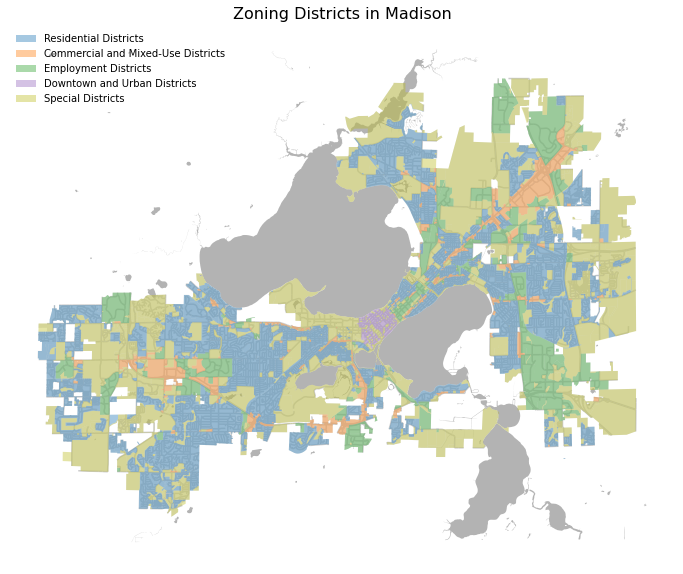

In [74]:

fig, ax = plt.subplots(figsize=(12, 10))
city.plot(ax=ax, color="0.9")
water.plot(ax=ax, color="0.7")
street.plot(ax=ax, color="0.8")

cnt = 0
handles = []
for key, val in zone_category.items():
    print(key)
    if len(zones[zones["ZONING_COD"].isin(zone_category[key])]) == 0:
        continue
    else:
        temp = zones[zones["ZONING_COD"].isin(zone_category[key])]
        c = colors[cnt]
        cnt += 1

        temp.plot(ax=ax, color=c, zorder=2, alpha=0.4, label=key, legend=True)

p0 = Patch(facecolor=colors[0], label=list(zone_category.keys())[0], alpha=0.4)
p1 = Patch(facecolor=colors[1], label=list(zone_category.keys())[1], alpha=0.4)
p2 = Patch(facecolor=colors[2], label=list(zone_category.keys())[2], alpha=0.4)
p3 = Patch(facecolor=colors[3], label=list(zone_category.keys())[3], alpha=0.4)
p4 = Patch(facecolor=colors[4], label=list(zone_category.keys())[4], alpha=0.4)

ax.set_title("Zoning Districts in Madison", size=16)
patches = [p0, p1, p2, p3, p4]
ax.legend(handles=patches, loc='upper left', frameon=False)
ax.set_axis_off()
plt.savefig("../report/11_16th/intro_png", dpi=300, bbox_inches="tight")

